In [1]:
#
# Project 2, starter code Part a
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle
from tqdm import tqdm

In [2]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 100
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)


    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

In [4]:
def cnn(images, c1_filters, c2_filters):
    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

    # C1 (50x24x24): Conv layer, 50 filters, window size 9x9, VALID padding, ReLU
    # S1 (50x12x12): Max pooling layer, window size 2x2, stride = 2, VALID padding
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, c1_filters], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
    b1 = tf.Variable(tf.zeros([c1_filters]), name='biases_1')  
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

    # C2 (60x8x8): Conv layer, 60 filters, window size 5x5, VALID padding, ReLU
    # S2 (60x4x4): Max pooling layer, window size 2x2, stride = 2, VALID padding
    W2 = tf.Variable(tf.truncated_normal([5, 5, c1_filters, c2_filters], stddev=1.0/np.sqrt(c1_filters*5*5)), name='weights_2')
    b2 = tf.Variable(tf.zeros([c2_filters]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

    # Flatten (dim = 60x4x4 = 960)
    dim = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value 
    pool_2_flat = tf.reshape(pool_2, [-1, dim])

    # F3: Fully connected layer of size 300 (960 -> 300)
    W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
    b3 = tf.Variable(tf.zeros([300]), name='biases_3')
    f3_logits = tf.matmul(pool_2_flat, W3) + b3

    # F4: Softmax layer of size 10 (300 -> 10)
    W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
    b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
    f4_logits = tf.matmul(f3_logits, W4) + b4

    return conv_1, pool_1, conv_2, pool_2, f4_logits

In [5]:
def main(c1_filters, c2_filters):
    trainX, trainY = load_data('./data_batch_1')
    # print(trainX.shape, trainY.shape)

    testX, testY = load_data('./test_batch_trim')
    # print(testX.shape, testY.shape)

    # Scaling the train & test inputs
    trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)
    testX = (testX - np.min(testX, axis = 0))/np.max(testX, axis = 0)

    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_CHANNELS*IMG_SIZE*IMG_SIZE]) # 3x32x32
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    c1, s1, c2, s2, logits = cnn(x, c1_filters, c2_filters)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # train_loss = []
        # test_acc = []

        for e in tqdm(range(epochs), desc='C1={} | C2={} '.format(c1_filters, c2_filters)):
            np.random.shuffle(idx)
            trainX, trainY = trainX[idx], trainY[idx]
            # temp_train_loss = []

            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                # temp_train_loss.append(loss.eval(feed_dict={x: trainX[start:end], y_: trainY[start:end]}))

            # _, loss_ = sess.run([train_step, loss], {x: trainX, y_: trainY})

            # trainLoss = np.mean(np.array(temp_train_loss))
            # train_loss.append(trainLoss)
            # testAcc = accuracy.eval(feed_dict={x: testX, y_: testY})
            # test_acc.append(testAcc)

            # if (e % 10 == 0 or e == epochs-1):
                # print('C1: ', c1_filters, ' | C2: ', c2_filters, ' | Epoch: ', e)

        test_acc = accuracy.eval(feed_dict={x: testX, y_: testY})
        print('Test acc: {}\n'.format(test_acc))
        return test_acc

In [6]:
# Main Program
if __name__ == '__main__':
    all_conv_filters = range(10, 311, 50) # 10, 60, 110, 160, 210, 260, 310
    all_test_acc = np.array([])
    
    for c1 in range(len(all_conv_filters)):
        for c2 in range(len(all_conv_filters)):
            all_test_acc = np.append(all_test_acc, main(all_conv_filters[c1], all_conv_filters[c2]))
    
    # all_test_acc[C1:C2]
    reshaped_test_acc = np.reshape(all_test_acc, (len(all_conv_filters), len(all_conv_filters)))

C1=10 | C2=10 : 100%|████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s]


Test acc: 0.3334999978542328



C1=10 | C2=60 : 100%|████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


Test acc: 0.3709999918937683



C1=10 | C2=110 : 100%|███████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


Test acc: 0.38499999046325684



C1=10 | C2=160 : 100%|███████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


Test acc: 0.37599998712539673



C1=10 | C2=210 : 100%|███████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


Test acc: 0.3944999873638153



C1=10 | C2=260 : 100%|███████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Test acc: 0.398499995470047



C1=10 | C2=310 : 100%|███████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Test acc: 0.40950000286102295



C1=60 | C2=10 : 100%|████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Test acc: 0.37299999594688416



C1=60 | C2=60 : 100%|████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Test acc: 0.3725000023841858



C1=60 | C2=110 : 100%|███████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Test acc: 0.39149999618530273



C1=60 | C2=160 : 100%|███████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Test acc: 0.39250001311302185



C1=60 | C2=210 : 100%|███████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


Test acc: 0.3919999897480011



C1=60 | C2=260 : 100%|███████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


Test acc: 0.3930000066757202



C1=60 | C2=310 : 100%|███████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Test acc: 0.40299999713897705



C1=110 | C2=10 : 100%|███████████████████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


Test acc: 0.3840000033378601



C1=110 | C2=60 : 100%|███████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Test acc: 0.3995000123977661



C1=110 | C2=110 : 100%|██████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Test acc: 0.3970000147819519



C1=110 | C2=160 : 100%|██████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.78s/it]


Test acc: 0.4020000100135803



C1=110 | C2=210 : 100%|██████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.99s/it]


Test acc: 0.4025000035762787



C1=110 | C2=260 : 100%|██████████████████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it]


Test acc: 0.41200000047683716



C1=110 | C2=310 : 100%|██████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.42s/it]


Test acc: 0.40450000762939453



C1=160 | C2=10 : 100%|███████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


Test acc: 0.39250001311302185



C1=160 | C2=60 : 100%|███████████████████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


Test acc: 0.398499995470047



C1=160 | C2=110 : 100%|██████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.16s/it]


Test acc: 0.4169999957084656



C1=160 | C2=160 : 100%|██████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.34s/it]


Test acc: 0.414000004529953



C1=160 | C2=210 : 100%|██████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]


Test acc: 0.4180000126361847



C1=160 | C2=260 : 100%|██████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]


Test acc: 0.4205000102519989



C1=160 | C2=310 : 100%|██████████████████████████████████████████████████████████████| 100/100 [05:08<00:00,  3.09s/it]


Test acc: 0.4154999852180481



C1=210 | C2=10 : 100%|███████████████████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


Test acc: 0.4009999930858612



C1=210 | C2=60 : 100%|███████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


Test acc: 0.40450000762939453



C1=210 | C2=110 : 100%|██████████████████████████████████████████████████████████████| 100/100 [04:27<00:00,  2.68s/it]


Test acc: 0.41350001096725464



C1=210 | C2=160 : 100%|██████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.97s/it]


Test acc: 0.4255000054836273



C1=210 | C2=210 : 100%|██████████████████████████████████████████████████████████████| 100/100 [05:27<00:00,  3.28s/it]


Test acc: 0.4235000014305115



C1=210 | C2=260 : 100%|██████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]


Test acc: 0.40799999237060547



C1=210 | C2=310 : 100%|██████████████████████████████████████████████████████████████| 100/100 [06:38<00:00,  3.98s/it]


Test acc: 0.42649999260902405



C1=260 | C2=10 : 100%|███████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]


Test acc: 0.40149998664855957



C1=260 | C2=60 : 100%|███████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.92s/it]


Test acc: 0.42250001430511475



C1=260 | C2=110 : 100%|██████████████████████████████████████████████████████████████| 100/100 [05:29<00:00,  3.29s/it]


Test acc: 0.4165000021457672



C1=260 | C2=160 : 100%|██████████████████████████████████████████████████████████████| 100/100 [06:05<00:00,  3.65s/it]


Test acc: 0.429500013589859



C1=260 | C2=210 : 100%|██████████████████████████████████████████████████████████████| 100/100 [06:39<00:00,  4.00s/it]


Test acc: 0.4205000102519989



C1=260 | C2=260 : 100%|██████████████████████████████████████████████████████████████| 100/100 [07:14<00:00,  4.34s/it]


Test acc: 0.42399999499320984



C1=260 | C2=310 : 100%|██████████████████████████████████████████████████████████████| 100/100 [07:56<00:00,  4.77s/it]


Test acc: 0.41850000619888306



C1=310 | C2=10 : 100%|███████████████████████████████████████████████████████████████| 100/100 [05:01<00:00,  3.02s/it]


Test acc: 0.3959999978542328



C1=310 | C2=60 : 100%|███████████████████████████████████████████████████████████████| 100/100 [05:34<00:00,  3.34s/it]


Test acc: 0.41499999165534973



C1=310 | C2=110 : 100%|██████████████████████████████████████████████████████████████| 100/100 [06:22<00:00,  3.83s/it]


Test acc: 0.4194999933242798



C1=310 | C2=160 : 100%|██████████████████████████████████████████████████████████████| 100/100 [06:57<00:00,  4.18s/it]


Test acc: 0.4230000078678131



C1=310 | C2=210 : 100%|██████████████████████████████████████████████████████████████| 100/100 [07:38<00:00,  4.59s/it]


Test acc: 0.4309999942779541



C1=310 | C2=260 : 100%|██████████████████████████████████████████████████████████████| 100/100 [08:18<00:00,  4.99s/it]


Test acc: 0.41999998688697815



C1=310 | C2=310 : 100%|██████████████████████████████████████████████████████████████| 100/100 [09:17<00:00,  5.57s/it]


Test acc: 0.43050000071525574



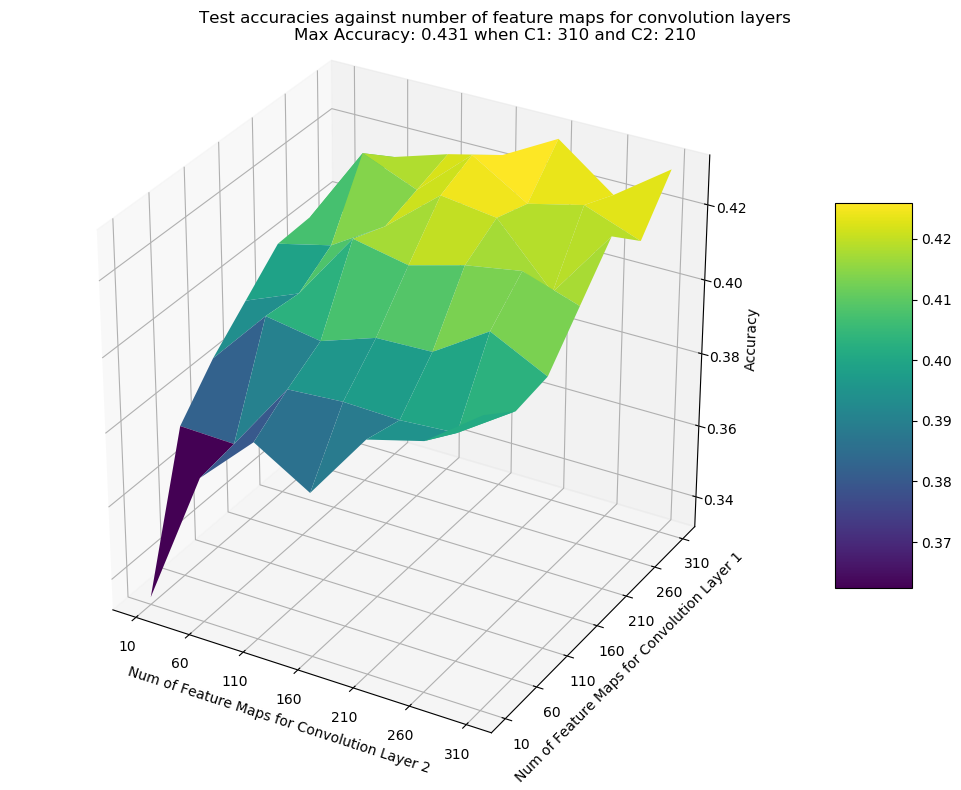

In [8]:
    # Plot all test accuracies
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8), dpi=100)
    ax = fig.gca(projection='3d')

    plt.suptitle('Test accuracies against number of feature maps for convolution layers\nMax Accuracy: {:.3f} when C1: {} and C2: {}'.format(max(all_test_acc), all_conv_filters[np.where(reshaped_test_acc == max(all_test_acc))[0][0]], all_conv_filters[np.where(reshaped_test_acc == max(all_test_acc))[1][0]]))
    
    # [C1:C2] == [X:Y] == indexing='ij'
    X, Y = np.meshgrid(all_conv_filters, all_conv_filters, indexing='ij')
    
    # Swap to [Y:X] for a better view (As graph increases towards the viewer)
    surf = ax.plot_surface(Y, X, reshaped_test_acc, rstride=1, cstride=1, cmap='viridis')
    ax.set_xlabel('Num of Feature Maps for Convolution Layer 2')
    ax.set_ylabel('Num of Feature Maps for Convolution Layer 1')
    ax.set_zlabel('Accuracy')
    
    plt.xticks(all_conv_filters)
    plt.yticks(all_conv_filters)
    plt.tight_layout()
    plt.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('./2.TestAcc_NumOfFM.png')

    plt.show()